In [1]:
%pylab inline
import pickle as pk

Populating the interactive namespace from numpy and matplotlib


In [2]:
#labels is the labels or the neighbors of a test point
#It consists of a list of 1000 arrays each corresponding to one test examples
# each array contains 60000 elements which are the labels of the 60000 trainining examples sorted by increasing 
# distance to the test example.

# with open('labels.pkl','br') as pklfile:
#     labels=pk.load(pklfile)
# len(labels), labels[0].shape

In [3]:
%pwd

'/Users/yoavfreund/academic.papers/papers/adaptive-kNN/notebooks'

In [4]:
!ls -lrth *.npz

-rw-r--r--  1 yoavfreund  staff   1.1G Apr 26 22:01 IndexByDistance.npz


In [5]:
X=np.load('IndexByDistance.npz')
indicesByDistance=X['a']

In [6]:
import mnist

def recast(x):
    return np.array(x,dtype=np.float32)
train_images = recast(mnist.train_images())
train_labels = mnist.train_labels()
test_images = recast(mnist.test_images())
test_labels = mnist.test_labels()

In [7]:
_range=3000

def find_sig(S,thr=5):
    """ S is a matrix of 10 X _range.
    entry S[i,j] is the significance associated with label i when considering j nearset neighbors.
    Find the first entry of x that is larger than thr.
    returns predicted_label,stopping_time
    """
    f=[]
    stopping_time=_range
    for i in range(10):
        f=np.nonzero(S[i,:]>thr)[0]
        if f.shape[0]>0:
            f=f[0]
            if stopping_time > f:
                stopping_time=f
                predicted_label=i
    if stopping_time<_range:
        return predicted_label,stopping_time
    # did not find anything with significance > thr, then take the one with highest significance
    _argmax=np.argmax(S,axis=1)
    _max = np.max(S,axis=1)
    predicted_label = np.argmax(_max)
    stopping_time = _argmax[predicted_label]
    #print(stopping_time)
    return predicted_label,stopping_time
            
    

In [8]:
from collections import Counter
def find_label_knn(test_index,k=5):
    L=labels[test_index]
    C=list(Counter(L[:k]).items())
    S=sorted(C,key=lambda x:x[1],reverse=True)
    return np.array(S).transpose()

In [9]:
def find_label_adaptive(test_index,thr=4):
    """Find label of test example test_index using adaptive k NN"""
    C=[]
    sig=[]
    P=np.zeros([10,_range])
    L=labels[test_index]
    scale=arange(1,_range+1,1)
    for i in range(10):
        C.append(np.cumsum(L==i))
        P[i,:]=(C[-1][:_range]-(scale/10))/sqrt(scale)
    predicted_label,stopping_time = find_sig(P,thr=thr)
    sigs_at_stop = P[:,stopping_time]
    I=argsort(sigs_at_stop)
    Sigs=sigs_at_stop[I]
    prediction=np.array([I[Sigs>0],Sigs[Sigs>0]],dtype=np.int16)
    return prediction[:,-1::-1]

In [10]:
def compute_errs(method="adaptive",**kwargs):
    errs=np.zeros([4,11])
    n=test_labels.shape[0]
    for i in range(n):
        if method=='adaptive':
            pred_label=find_label_adaptive(i,**kwargs)
        else:
            pred_label=find_label_knn(i,**kwargs)

        prediction=int(pred_label[0,0])
        err = 0 #prediction error
        labelSet=set(pred_label[0,:])
        if prediction != test_labels[i]:
            err=1 # incorrect prediction
        if test_labels[i] in labelSet:
            err+=2 # prediction in prediction set
        multi=pred_label.shape[1]
        if prediction==-1:
            multi=0
            err=1
        errs[err,multi]+=1
        if i%100==0:
            print('\r',i,end='')
    errs=np.array(errs,dtype=np.int16)
    print()       

    cr_sums=np.sum(errs,axis=1)
    print('size of set total',''.join(["%5d"%x for x in range(11)]))
    print('total      %6d'%np.sum(cr_sums),''.join(["%5d"%x for x in np.sum(errs,axis=0)]))
    print('incorrect  %6d'%np.sum(cr_sums[[0,1,3]]),''.join(["%5d"%x for x in np.sum(errs,axis=0)-errs[2,:]]))
    #print('in set     ',''.join(["%6d"%x for x in errs[2,:]+errs[3,:]]))
    print('not in set %6d'%np.sum(cr_sums[[0,1]]),''.join(["%5d"%x for x in errs[0,:]+errs[1,:]]))
    return cr_sums

In [11]:
knn_err=[]

In [12]:
for p in arange(0,1,0.1):
    print(50*'=','p=',p)

    random=np.random.choice(10,train_labels.shape)

    combined=np.dstack((train_labels,random))

    selector=np.random.binomial(1,p,random.shape)
    sel=np.dstack([1-selector,selector])

    noisy_labels=sum(combined*sel,axis=2).squeeze()
    noisy_labels.shape

    labels=noisy_labels[indicesByDistance]
    labels.shape

    labels[:3,:10]

    for i in range(12):
        k=2**i
        print('='*40,'knn with k=',k,end=', ')
        cr_sums=compute_errs('knn',k=k)
        #print(cr_sums)
        knn_err.append({'method':'knn','p':p,'k':k,'err':np.sum(cr_sums[[0,1,3]])/100.})

    for theta in range(1,4):
        print('='*40,'adaptive NN with theta=',theta)
        cr_sums=compute_errs('adaptive',thr=theta)
        knn_err.append({'method':'adaptive','p':p,'theta':theta,'err':np.sum(cr_sums[[0,1,3]])/100.})

knn_err

================================================== p= 0.0
 9900=================================== knn with k= 1, 
size of set total     0    1    2    3    4    5    6    7    8    9   10
total       10000     010000    0    0    0    0    0    0    0    0    0
incorrect     277     0  277    0    0    0    0    0    0    0    0    0
not in set    277     0  277    0    0    0    0    0    0    0    0    0
 9900=================================== knn with k= 2, 
size of set total     0    1    2    3    4    5    6    7    8    9   10
total       10000     0 9636  364    0    0    0    0    0    0    0    0
incorrect     277     0  112  165    0    0    0    0    0    0    0    0
not in set    143     0  112   31    0    0    0    0    0    0    0    0
 9900=================================== knn with k= 4, 
size of set total     0    1    2    3    4    5    6    7    8    9   10
total       10000     0 9282  618   91    9    0    0    0    0    0    0
incorrect     239     0   57  1

 9900=================================== knn with k= 256, 
size of set total     0    1    2    3    4    5    6    7    8    9   10
total       10000     0    0    0    0    0    0   11  106  857 3137 5889
incorrect     681     0    0    0    0    0    0    0    0   26  151  504
not in set      0     0    0    0    0    0    0    0    0    0    0    0
 9900=================================== knn with k= 512, 
size of set total     0    1    2    3    4    5    6    7    8    9   10
total       10000     0    0    0    0    0    0    0    0    2  316 9682
incorrect     876     0    0    0    0    0    0    0    0    0   11  865
not in set      0     0    0    0    0    0    0    0    0    0    0    0
 9900=================================== knn with k= 1024, 
size of set total     0    1    2    3    4    5    6    7    8    9   10
total       10000     0    0    0    0    0    0    0    0    0    2 9998
incorrect    1138     0    0    0    0    0    0    0    0    0    1 1137
not in s

 9900=================================== knn with k= 2, 
size of set total     0    1    2    3    4    5    6    7    8    9   10
total       10000     0 5154 4846    0    0    0    0    0    0    0    0
incorrect    2936     0  166 2770    0    0    0    0    0    0    0    0
not in set    932     0  166  766    0    0    0    0    0    0    0    0
 9900=================================== knn with k= 4, 
size of set total     0    1    2    3    4    5    6    7    8    9   10
total       10000     0 2619 4352 2481  548    0    0    0    0    0    0
incorrect    1003     0   16  236  349  402    0    0    0    0    0    0
not in set    163     0   16   40   61   46    0    0    0    0    0    0
 9900=================================== knn with k= 8, 
size of set total     0    1    2    3    4    5    6    7    8    9   10
total       10000     0  691 2503 3363 2377  857  194   15    0    0    0
incorrect     350     0    2   30   71  118   74   48    7    0    0    0
not in set     

 9900=================================== knn with k= 512, 5600
size of set total     0    1    2    3    4    5    6    7    8    9   10
total       10000     0    0    0    0    0    0    0    0    0    010000
incorrect     865     0    0    0    0    0    0    0    0    0    0  865
not in set      0     0    0    0    0    0    0    0    0    0    0    0
 9900=================================== knn with k= 1024, 
size of set total     0    1    2    3    4    5    6    7    8    9   10
total       10000     0    0    0    0    0    0    0    0    0    010000
incorrect    1131     0    0    0    0    0    0    0    0    0    0 1131
not in set      0     0    0    0    0    0    0    0    0    0    0    0
 9900=================================== knn with k= 2048, 
size of set total     0    1    2    3    4    5    6    7    8    9   10
total       10000     0    0    0    0    0    0    0    0    0    010000
incorrect    1557     0    0    0    0    0    0    0    0    0    0 1557
not

 9900=================================== knn with k= 4, 
size of set total     0    1    2    3    4    5    6    7    8    9   10
total       10000     0  439 2496 4643 2422    0    0    0    0    0    0
incorrect    3641     0    5  330 1358 1948    0    0    0    0    0    0
not in set   1000     0    5   89  480  426    0    0    0    0    0    0
 9900=================================== knn with k= 8, 
size of set total     0    1    2    3    4    5    6    7    8    9   10
total       10000     0   13  258 1459 3044 3315 1552  342   17    0    0
incorrect    1852     0    0    3   62  316  663  623  170   15    0    0
not in set    164     0    0    1    9   36   64   40   13    1    0    0
 9900=================================== knn with k= 16, 
size of set total     0    1    2    3    4    5    6    7    8    9   10
total       10000     0    0    3   30  284 1279 2659 3189 1955  530   71
incorrect     674     0    0    0    1    4   26  114  218  214   82   15
not in set    

 9900=================================== knn with k= 1024, 
size of set total     0    1    2    3    4    5    6    7    8    9   10
total       10000     0    0    0    0    0    0    0    0    0    010000
incorrect    1134     0    0    0    0    0    0    0    0    0    0 1134
not in set      0     0    0    0    0    0    0    0    0    0    0    0
 9900=================================== knn with k= 2048, 
size of set total     0    1    2    3    4    5    6    7    8    9   10
total       10000     0    0    0    0    0    0    0    0    0    010000
incorrect    1543     0    0    0    0    0    0    0    0    0    0 1543
not in set      0     0    0    0    0    0    0    0    0    0    0    0
======================================== adaptive NN with theta= 1
 9900
size of set total     0    1    2    3    4    5    6    7    8    9   10
total       10000     0 1867 1602 2850 2134 1270  276    1    0    0    0
incorrect    1193     0  442  137  280  204  105   24    1    0    

 9900=================================== knn with k= 8, 
size of set total     0    1    2    3    4    5    6    7    8    9   10
total       10000     0    0    7  128 1105 3368 3814 1461  117    0    0
incorrect    7144     0    0    2   50  662 2295 2882 1153  100    0    0
not in set   1944     0    0    0   24  243  726  722  221    8    0    0
 9900=================================== knn with k= 16, 
size of set total     0    1    2    3    4    5    6    7    8    9   10
total       10000     0    0    0    0    1   67  641 2407 3857 2491  536
incorrect    6193     0    0    0    0    1   32  330 1392 2390 1679  369
not in set    356     0    0    0    0    1    3   28  120  157   47    0
 9900=================================== knn with k= 32, 
size of set total     0    1    2    3    4    5    6    7    8    9   10
total       10000     0    0    0    0    0    0    1   41  502 3304 6152
incorrect    4811     0    0    0    0    0    0    0   12  205 1501 3093
not in set   

[{'method': 'knn', 'p': 0.0, 'k': 1, 'err': 2.77},
 {'method': 'knn', 'p': 0.0, 'k': 2, 'err': 2.77},
 {'method': 'knn', 'p': 0.0, 'k': 4, 'err': 2.39},
 {'method': 'knn', 'p': 0.0, 'k': 8, 'err': 2.62},
 {'method': 'knn', 'p': 0.0, 'k': 16, 'err': 3.15},
 {'method': 'knn', 'p': 0.0, 'k': 32, 'err': 3.72},
 {'method': 'knn', 'p': 0.0, 'k': 64, 'err': 4.48},
 {'method': 'knn', 'p': 0.0, 'k': 128, 'err': 5.52},
 {'method': 'knn', 'p': 0.0, 'k': 256, 'err': 6.86},
 {'method': 'knn', 'p': 0.0, 'k': 512, 'err': 8.8},
 {'method': 'knn', 'p': 0.0, 'k': 1024, 'err': 11.38},
 {'method': 'knn', 'p': 0.0, 'k': 2048, 'err': 15.79},
 {'method': 'adaptive', 'p': 0.0, 'theta': 1, 'err': 2.4},
 {'method': 'adaptive', 'p': 0.0, 'theta': 2, 'err': 3.39},
 {'method': 'adaptive', 'p': 0.0, 'theta': 3, 'err': 4.59},
 {'method': 'knn', 'p': 0.1, 'k': 1, 'err': 11.06},
 {'method': 'knn', 'p': 0.1, 'k': 2, 'err': 11.06},
 {'method': 'knn', 'p': 0.1, 'k': 4, 'err': 3.09},
 {'method': 'knn', 'p': 0.1, 'k': 8, '

In [13]:
import pickle as pk

pk.dump(knn_err,open('knn_err3000.pkl','bw'))

#knn_err=pk.load(open('knn_err3000.pkl','br'))


In [ ]:
knn_err

In [14]:
adaptive = np.zeros(10)
for row in knn_err:
    if row['method']=='adaptive' and row['theta']==2:
        i=int(10*row['p'])
        err=row['err']
        adaptive[i] = err
adaptive

array([ 3.39,  3.64,  3.96,  4.06,  4.63,  5.37,  6.33,  7.43, 10.45,
       16.85])

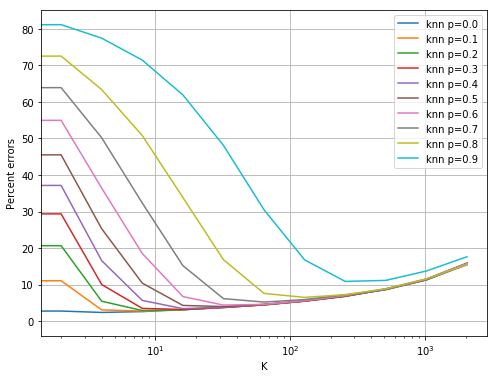

In [15]:
err=np.zeros(12)
K=np.zeros(12)
knn_best=[]
figure(figsize=[8,6])
for j in range(10):
    p=j/10.
    A=adaptive[j]; A=[A]*12
    _min=100
    for row in knn_err:
        if abs(row['p']-p)<0.001 and row['method']=='knn':
            i=int(log2(row['k']+1))
            err[i] = row['err']
            if row['err']< _min:
                _min=row['err']
                _min_i=row['k']
            K[i]=2**i
    semilogx(K,err,label='knn p=%2.1f'%p);
    #semilogx(K,A,label='adapt p=%2.1f'%p);
    knn_best.append((j/10.,_min_i,_min))
    
#ylim([0,15])
legend()
ylabel('Percent errors')
xlabel('K')
grid()

In [17]:
for i in range(10):
    L=knn_best[i]
    print(" %3.1f & %4d & %5.2f & %5.2f \\\\ \\hline"%(L[0],L[1],L[2],adaptive[i]))

 0.0 &    4 &  2.39 &  3.39 \\ \hline
 0.1 &    8 &  2.76 &  3.64 \\ \hline
 0.2 &    8 &  2.92 &  3.96 \\ \hline
 0.3 &   16 &  3.20 &  4.06 \\ \hline
 0.4 &   16 &  3.43 &  4.63 \\ \hline
 0.5 &   32 &  4.00 &  5.37 \\ \hline
 0.6 &   32 &  4.40 &  6.33 \\ \hline
 0.7 &   64 &  5.23 &  7.43 \\ \hline
 0.8 &  128 &  6.51 & 10.45 \\ \hline
 0.9 &  256 & 10.88 & 16.85 \\ \hline


## Old stuff

In [ ]:
i=8520 # a 4 that looks like a 9
i=20
#i=23
#i=320

threshold=5
L=labels[i]
true_label=test_labels[i]
imshow(test_images[i,:,:],cmap='gray')
title(str(true_label))

figure(figsize=[10,8])
_range=1000
C=[]
sig=[]
scale=arange(1,_range+1,1)
for i in range(10):
    C.append(np.cumsum(L==i))
    P=(C[-1][:_range]-(scale/10))/sqrt(scale)
    sig.append(find_sig(P))
    _name=str(i)
    if i==true_label:
        _name+= ' true label '
    plot(P,label=_name)
legend()
grid()
print(sig)

In [ ]:
P[:10]

In [ ]:
np.nonzero(P>1)[0].shape

In [ ]:
# instead of giving up when reaching _range, use the label that showed the largest "p".